In [25]:
import re  # Procesamiento de Texto
import pandas as pd  
from time import time  # Medir tiempo de ejecucion
import multiprocessing
import logging  # Sacar logs del modelo

import numpy as np
import matplotlib.pyplot as plt
 
import seaborn as sns

from collections import defaultdict  
from sklearn.model_selection import train_test_split

import spacy  # Procesamiento NLP

In [26]:
# DATA DIR 
url = 'https://raw.githubusercontent.com/pfernandez-sanofi/ml_tutorials/main/DATA/simpson_dataset.csv'
# cargamos datos 
df = pd.read_csv(url)
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [27]:
df = df.dropna().reset_index(drop=True) # eliminamos nulos 

# Filtrando Homero 

df['is_homer'] = [
    1 if "homer" in x.lower() else 0 for x
    in df.raw_character_text
]

In [28]:
df.is_homer.value_counts() / len(df) 

0    0.78451
1    0.21549
Name: is_homer, dtype: float64

<AxesSubplot:>

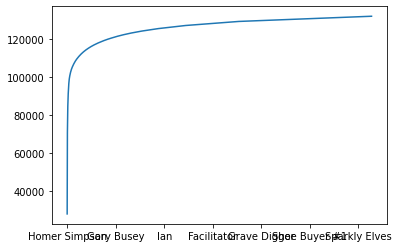

In [29]:
# Vemos el plot cumulativo donde tenemos los personas menos relevantes
df.raw_character_text.value_counts().cumsum().plot()

In [30]:
cumsum_participation = df.raw_character_text.value_counts().cumsum()
mask = cumsum_participation <= 110_000
rel_characters = cumsum_participation[mask].index
# Filter for the relevant characters
df = df[df.raw_character_text.isin(rel_characters)]

In [31]:
df.is_homer.value_counts() / len(df) 

0    0.744104
1    0.255896
Name: is_homer, dtype: float64

In [32]:
len(df)

109982

# Reducimos tamaño del DF para evitar problemas de memoria

In [33]:
# reducimos a la 50% de los not homer
# Esto también nos ayudará a balancear el modelo

sample_size = int(
     len(
         df.query(
            "is_homer == 0"
        )
    ) * 0.5
)
to_model_df = df.query(
    "is_homer == 1"
).append(
    df.query(
        "is_homer == 0"
).sample(sample_size)
).reset_index(drop=True)

/var/folders/g9/cjl__p5n18j7_y_2lx39ww4m0000gn/T/ipykernel_3213/3182038189.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  to_model_df = df.query(


In [34]:
to_model_df.is_homer.value_counts() / len(to_model_df) 

0    0.592488
1    0.407512
Name: is_homer, dtype: float64

In [35]:
len(to_model_df)

69063

In [36]:
to_model_sample_size = 20_000  # pueden incluso disminuir este valor
to_model_df = to_model_df.sample(to_model_sample_size)

In [37]:
to_model_df.is_homer.value_counts() / len(to_model_df) 

0    0.58965
1    0.41035
Name: is_homer, dtype: float64

In [38]:
nlp = spacy.load(
  'en_core_web_sm',  # Capaz sea necesario descargar modelo de Spacy English.
  disable=['ner', 'parser']  # desactivamos modelos por facilidad de procesamiento
  ) 

def cleaning(doc):
  """
  Lemmatiza y elimina stopwords
  Necesitamos un doc como lo describe spacy
  :param doc: DOC según lo describe Spacy. 
  :return: Una cadena de texto. 
  """
  txt = [token.lemma_ for token in doc if not token.is_stop]
  # Word2Vec usa el contexto para entender la reperesentacion de la palabra
  # Si la oracion es corta, no va a aprender mucho
  return ' '.join(txt)
# Reemplazamos todo lo que no sea alphanum por espacio
brief_cleaning = (
  re.sub(r"[^A-Za-z0-9']+", 
  ' ', 
  str(row)).lower().strip() for row in to_model_df['spoken_words']  # por cada fila en df.
  )

In [39]:
# Usamos el método Pipe de Spacy para procesar con mayor velocidad
t = time() # Calculamos tiempo

txt = [
    cleaning(doc) for doc in nlp.pipe(
        brief_cleaning, # función que def antes
        batch_size=5000, 
        n_process=-1 # usamos todos los cores
    )
]
# medimos tiempo de ejecución 
t_ = round((time() - t) / 60, 2) # Tiempo de ejecucion en mins
print(f'Tiempo de ejecución: {t_} mins')

In [17]:
to_model_df['clean_txt'] = txt
to_model_df = to_model_df[to_model_df.clean_txt.notnull()]

In [18]:
len(to_model_df)

12982

In [19]:
Y = to_model_df.is_homer.values
X = to_model_df.clean_txt

# Set entrenamiento y prueba con Keras
df_train, df_test, Ytrain, Ytest = train_test_split(
    X, Y, test_size=0.30, stratify=Y
)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


In [21]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report, accuracy_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [22]:
# Creamos el Sklearn Pipeline con todas las transformaciones mencionadas arriba 
text_clf_rf = Pipeline([
  ('vect', CountVectorizer()), 
  ('tfidf', TfidfTransformer()), # transforma por frecuencia 
  ('clf_rf',
    RandomForestClassifier(
      n_estimators=200, 
      verbose=True, # Verbose -> barra progreso
      oob_score=True, 
      min_samples_split=2
    )
  )
  ]
)
# Realizamos un entrenamiento con CV para tener certeza de los resultados
# Y también poder probar cuál modelo es el mejor. 

scoring = "f1_micro" # metric to optimize can be 'recall'
cv = 2 # cross validation
parameters = { 
  'vect__ngram_range': [(1, 1), (1, 2)],
  #'tfidf__use_idf': (True, False),
  'clf_rf__n_estimators': (400, 600),
  'clf_rf__min_samples_split': (2, 5)
}

# Creamos todo el pipeline para que ademas ejecute cambio de parametros 
grid = GridSearchCV(text_clf_rf, cv=cv, param_grid=parameters, 
                    scoring=scoring, n_jobs = -1)

In [23]:
# Entrenamos 
grid.fit(df_train, Ytrain) # Toma TIEMPO!!! 

# summarize results
print(f"Resultados en base a {scoring}")
print("Mejor: %f usando %s" % (grid.best_score_, 
    grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Resultado medio: {mean}, SD: {stdev}  con: {param}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   15.2s finished
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   15.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapse

Resultados en base a f1_micro
Mejor: 0.624078 usando {'clf_rf__min_samples_split': 5, 'clf_rf__n_estimators': 600, 'vect__ngram_range': (1, 2)}
Resultado medio: 0.6113110190418318, SD: 0.016769966873661113  con: {'clf_rf__min_samples_split': 2, 'clf_rf__n_estimators': 400, 'vect__ngram_range': (1, 1)}
Resultado medio: 0.6095499954658614, SD: 0.019191201717237205  con: {'clf_rf__min_samples_split': 2, 'clf_rf__n_estimators': 400, 'vect__ngram_range': (1, 2)}
Resultado medio: 0.6114207636031908, SD: 0.019521137805259936  con: {'clf_rf__min_samples_split': 2, 'clf_rf__n_estimators': 600, 'vect__ngram_range': (1, 1)}
Resultado medio: 0.6138424102008042, SD: 0.014018505292153538  con: {'clf_rf__min_samples_split': 2, 'clf_rf__n_estimators': 600, 'vect__ngram_range': (1, 2)}
Resultado medio: 0.6195655491113088, SD: 0.007855225536578525  con: {'clf_rf__min_samples_split': 5, 'clf_rf__n_estimators': 400, 'vect__ngram_range': (1, 1)}
Resultado medio: 0.6236373605655505, SD: 0.007304540842900276

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



accuracy 0.6169448010269576


              precision    recall  f1-score   support

           0       0.66      0.74      0.70      2328
           1       0.53      0.44      0.48      1567

    accuracy                           0.62      3895
   macro avg       0.59      0.59      0.59      3895
weighted avg       0.61      0.62      0.61      3895

Confusion matrix, without normalization


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.4s finished


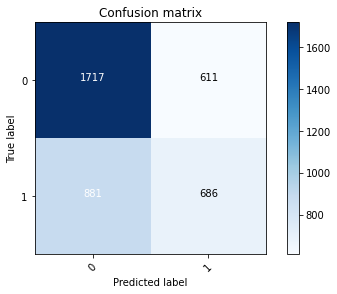

In [24]:
# Revisamos resultados del mejor modelo 
m_best = grid.best_estimator_ # mejor modelo
y_pred = m_best.predict(df_test)
# Metricas de precision
print('\naccuracy %s' % accuracy_score(y_pred, Ytest))
print("\n")
print(classification_report(Ytest, y_pred,))

# plot 
cm = confusion_matrix(Ytest, y_pred)
plot_confusion_matrix(cm, list(range(2)))